# Udacity Data Scientist Nanodegree

## Project: Writing a Data Scientist Blog Post

### Analyising that Airbnb data

### 1. Business Understanding
In this notebook, I will focus on answering three business questions using descriptive analysis, inferential statistics, and machine learning:
1. Which areas get the best rental rates? Help new host understand if thier property is in a wanted aread  
2. What are the best types of property to rent? This will give an idea of what people are looking for
3. What are the most important features for predicting price? Give an idea of what people are looking for in a property


### 2. Data Understanding
2.1 Load the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

In [2]:
# load boston calendar data
boston_calendar = pd.read_csv('data/calendar_boston.csv', delimiter = ',')
boston_calendar['city'] = 'Boston'
boston_calendar.head()

,listing_id,date,available,price,city
0,12147973,2017-09-05,f,NaN,Boston
1,12147973,2017-09-04,f,NaN,Boston
2,12147973,2017-09-03,f,NaN,Boston
3,12147973,2017-09-02,f,NaN,Boston
4,12147973,2017-09-01,f,NaN,Boston


In [3]:
# load boston listing data
boston_list = pd.read_csv('data/listings_boston.csv', delimiter = ',')
boston_list['city'] = 'Boston'
boston_list.drop(labels = ['access', 'interaction', 'house_rules'], axis = 1, inplace = True)
boston_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [4]:
boston_list.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

In [31]:
# load boston review data
#have decide not to analysis booking rates and sentiment so will not require this information  
boston_review = pd.read_csv('data/reviews_boston.csv', delimiter = ',')
boston_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [6]:
# load seattle calendar data
seattle_calendar = pd.read_csv('data/calendar_seattle.csv', delimiter = ',')
seattle_calendar['city'] = 'Seattle'
seattle_calendar.head()

,listing_id,date,available,price,city
0,241032,2016-01-04,t,$85.00,Seattle
1,241032,2016-01-05,t,$85.00,Seattle
2,241032,2016-01-06,f,NaN,Seattle
3,241032,2016-01-07,f,NaN,Seattle
4,241032,2016-01-08,f,NaN,Seattle


In [7]:
# load seattle listing data
seattle_list = pd.read_csv('data/listings_seattle.csv', delimiter = ',')
seattle_list['city'] = 'Seattle'
seattle_list.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [8]:
# merge together
calendar_all = pd.concat([boston_calendar, seattle_calendar])
calendar_all.date = pd.to_datetime(calendar_all.date)
calendar_all['weekday'] = calendar_all['date'].dt.dayofweek
calendar_all['price']= calendar_all.price.str.replace(',|\$','').fillna(0).astype(float)

listings_all = pd.concat([boston_list, seattle_list])

In [9]:
#check shape and strcuture
shape_cal = calendar_all.shape
shape_lis = listings_all.shape

print('The shape of the combine calendar and listing is: {} row and cloumns for the calendar and {} row and cloumns for the listing'.format(shape_cal, shape_lis))
listings_all.head()

The shape of the combine calendar and listing is: (2702460, 6) row and cloumns for the calendar and (7403, 92) row and cloumns for the listing


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [10]:
calendar_all.head()

,listing_id,date,available,price,city,weekday
0,12147973,2017-09-05,f,0.0,Boston,1
1,12147973,2017-09-04,f,0.0,Boston,0
2,12147973,2017-09-03,f,0.0,Boston,6
3,12147973,2017-09-02,f,0.0,Boston,5
4,12147973,2017-09-01,f,0.0,Boston,4


2.2 Check the data range
Once data is loaded and merged, I will now look at how much missing data and data ranges

In [11]:
listings_all.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,7.403000e+03,7.403000e+03,7.403000e+03,7401.000000,7401.000000,7403.000000,7403.000000,7403.000000,7373.000000,7387.000000,...,5943.000000,5922.000000,5932.000000,5925.000000,5934.000000,5926.000000,5926.000000,0.0,7403.000000,6020.000000
mean,6.950001e+06,2.016049e+13,2.021053e+07,32.222537,32.222537,45.067727,-97.515448,3.200189,1.241150,1.282659,...,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,NaN,7.686073,2.028161
std,4.052397e+06,4.009296e+08,1.962309e+07,123.585161,123.585161,2.643568,25.613198,1.890166,0.549408,0.823251,...,8.207451,0.821783,0.999271,0.682247,0.656589,0.775312,0.892824,NaN,21.465871,1.968696
min,3.335000e+03,2.016010e+13,4.193000e+03,0.000000,0.000000,42.235942,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.010000
25%,3.864100e+06,2.016010e+13,4.343164e+06,1.000000,1.000000,42.345668,-122.330837,2.000000,1.000000,1.000000,...,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.590000
50%,7.035240e+06,2.016010e+13,1.448650e+07,1.000000,1.000000,47.542907,-122.276419,2.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000,1.370000
75%,9.500804e+06,2.016091e+13,3.028359e+07,4.000000,4.000000,47.624460,-71.079518,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000,2.890000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,47.733358,-71.000100,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,136.000000,19.150000


2.3 Determine what is noise and remove
Let start with removing information not required to answer my questions:
1. the urls linked to the images
2. text descriptions
3. names such as host_name

In [12]:
# list of columns/feature to keep
cols = ['id', 'host_id', 'host_since', 'last_scraped', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 
        'host_is_superhost','host_identity_verified', 'neighbourhood_cleansed', 'city', 'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'bathrooms','bedrooms', 'beds','bed_type','amenities', 'square_feet', 
        'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 
        'has_availability', 'availability_365', 'number_of_reviews','first_review', 'review_scores_rating', 
        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
        'review_scores_value', 'requires_license', 'license', 'instant_bookable', 'cancellation_policy', 
        'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', 
        'reviews_per_month']
listing_rm = listings_all[cols]

listing_rm.head()

,id,host_id,host_since,last_scraped,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,...,review_scores_communication,review_scores_value,requires_license,license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,31303940,2015-04-15,2016-09-07,NaN,NaN,NaN,f,f,Roslindale,...,NaN,NaN,f,NaN,f,moderate,f,f,1,NaN
1,3075044,2572247,2012-06-07,2016-09-07,within an hour,100%,100%,f,t,Roslindale,...,10.0,9.0,f,NaN,t,moderate,f,f,1,1.30
2,6976,16701,2009-05-11,2016-09-07,within a few hours,100%,88%,t,t,Roslindale,...,10.0,10.0,f,NaN,f,moderate,t,f,1,0.47
3,1436513,6031442,2013-04-21,2016-09-07,within a few hours,100%,50%,f,f,Roslindale,...,10.0,10.0,f,NaN,f,moderate,f,f,1,1.00
4,7651065,15396970,2014-05-11,2016-09-07,within an hour,100%,100%,t,t,Roslindale,...,10.0,10.0,f,NaN,f,flexible,f,f,1,2.25


### 3. Data Preparation

3.1 Reviewing data missing from columns

license                        1.000000
square_feet                    0.979333
security_deposit               0.566662
has_availability               0.484263
cleaning_fee                   0.288667
review_scores_accuracy         0.200054
review_scores_checkin          0.199649
review_scores_value            0.199514
review_scores_cleanliness      0.198703
review_scores_communication    0.198433
dtype: float64

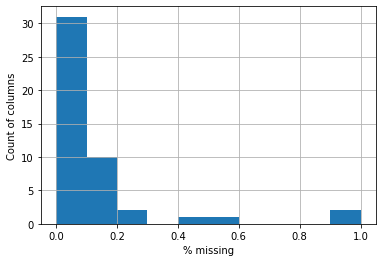

In [13]:
nan_cols = listing_rm.isnull().mean().sort_values(ascending = False)
graph = nan_cols.hist()  
graph.set_xlabel("% missing")
graph.set_ylabel("Count of columns")
nan_cols.head(n=10)

In [14]:
listing_rm = listing_rm.drop(labels = ['license', 'square_feet'], axis = 1)

listing_rm.dtypes

id                                    int64
host_id                               int64
host_since                           object
last_scraped                         object
host_response_time                   object
host_response_rate                   object
host_acceptance_rate                 object
host_is_superhost                    object
host_identity_verified               object
neighbourhood_cleansed               object
city                                 object
latitude                            float64
longitude                           float64
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
amenities                            object
price                                object
security_deposit                

3.2 Review and change formatting 
A number of features should have a float/integer type but are currently showing as a string or object

In [15]:
#Remove nan's and special characters from columns that should be numbers
listing_clean = listing_rm.copy()
listing_clean['security_deposit'] = listing_clean.security_deposit.str.replace(',|\$','').fillna(0).astype(float)
listing_clean['cleaning_fee'] = listing_clean.cleaning_fee.str.replace(',|\$','').fillna(0).astype(float)
listing_clean['price'] = listing_clean.price.str.replace(',|\$','').fillna(0).astype(float)
listing_clean['extra_people'] = listing_clean.extra_people.str.replace(',|\$','').fillna(0).astype(float)
listing_clean['host_response_rate'] = (listing_clean.host_response_rate.str.replace(',|\%','').fillna(0).astype(float))/100
listing_clean['host_acceptance_rate'] = (listing_clean.host_acceptance_rate.str.replace(',|\%','').fillna(0).astype(float))/100
listing_clean['last_scraped'] = pd.to_datetime(listing_clean['last_scraped'])
listing_clean['host_since'] = pd.to_datetime(listing_clean['host_since'])


listing_clean.dtypes

id                                           int64
host_id                                      int64
host_since                          datetime64[ns]
last_scraped                        datetime64[ns]
host_response_time                          object
host_response_rate                         float64
host_acceptance_rate                       float64
host_is_superhost                           object
host_identity_verified                      object
neighbourhood_cleansed                      object
city                                        object
latitude                                   float64
longitude                                  float64
property_type                               object
room_type                                   object
accommodates                                 int64
bathrooms                                  float64
bedrooms                                   float64
beds                                       float64
bed_type                       

In [16]:
#drop rows that don't have pricing 
listing_clean = listing_clean.dropna(subset=['price'], axis = 0)

In [17]:
# look to see if property type and locating have an affect on price (to help answer question 1) and check data makes sense 
type_mean =listing_clean.groupby(['property_type'])['price'].mean().sort_values(ascending = False)
type_mean

property_type
Guesthouse         289.000000
Boat               274.250000
Villa              189.500000
Condominium        179.186335
Loft               160.240506
Apartment          158.626389
Other              153.641026
Townhouse          135.604651
House              132.167320
Entire Floor       122.000000
Bed & Breakfast    121.153846
Camper/RV          116.142857
Bungalow           115.615385
Cabin              104.666667
Treehouse          101.000000
Yurt               100.000000
Chalet              98.500000
Tent                54.000000
Dorm                51.000000
Name: price, dtype: float64

In [18]:
neighbourhood_value =listing_clean.groupby(['neighbourhood_cleansed'])['price'].apply(pd.Series.mode).sort_values(ascending = False)
neighbourhood_value

neighbourhood_cleansed   
Bay Village             0    500.0
Fauntleroy              9    495.0
Windermere              9    400.0
Leather District        4    390.0
Holly Park              5    375.0
                             ...  
Bitter Lake             0     39.0
Ravenna                 0     39.0
Dunlap                  1     38.0
                        0     36.0
Mid-Beacon Hill         0     35.0
Name: price, Length: 262, dtype: float64

3.3 Review remainder of missing data and impute values

In [66]:
#starting with numerical data impute missing values
listing_clean_num = listing_clean.select_dtypes(include=['float64', 'int64'])
listing_clean_num.head()

,id,host_id,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,calculated_host_listings_count,reviews_per_month
0,12147973,31303940,0.0,0.00,42.282619,-71.133068,4,1.5,2.0,3.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,3075044,2572247,1.0,1.00,42.286241,-71.134374,2,1.0,1.0,1.0,...,359,36,94.0,10.0,9.0,10.0,10.0,9.0,1,1.30
2,6976,16701,1.0,0.88,42.292438,-71.135765,2,1.0,1.0,1.0,...,319,41,98.0,10.0,9.0,10.0,10.0,10.0,1,0.47
3,1436513,6031442,1.0,0.50,42.281106,-71.121021,4,1.0,1.0,2.0,...,98,1,100.0,10.0,10.0,10.0,10.0,10.0,1,1.00
4,7651065,15396970,1.0,1.00,42.284512,-71.136258,2,1.5,1.0,2.0,...,334,29,99.0,10.0,10.0,10.0,10.0,10.0,1,2.25


In [67]:
listing_clean_num.isnull().mean().sort_values(ascending = False)

review_scores_accuracy            0.200054
review_scores_checkin             0.199649
review_scores_value               0.199514
review_scores_cleanliness         0.198703
review_scores_communication       0.198433
review_scores_rating              0.197217
reviews_per_month                 0.186816
bathrooms                         0.004052
bedrooms                          0.002161
beds                              0.001351
host_id                           0.000000
host_response_rate                0.000000
host_acceptance_rate              0.000000
latitude                          0.000000
longitude                         0.000000
accommodates                      0.000000
guests_included                   0.000000
price                             0.000000
security_deposit                  0.000000
cleaning_fee                      0.000000
calculated_host_listings_count    0.000000
extra_people                      0.000000
minimum_nights                    0.000000
maximum_nig

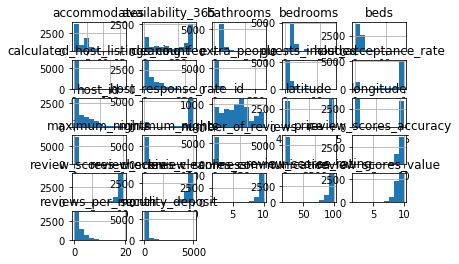

In [68]:
#have a look at the data and deside what method to use to impute the missing values 
listing_clean_num.hist();

In [69]:
# impute the missing values and drop not required column for analysis 

listing_clean_num= listing_clean_num.drop(['id','host_id', 'latitude', 'longitude'], axis =1)
fill_median = lambda col: col.fillna(col.median())

listing_clean_num.apply(fill_median, axis = 0)


,host_response_rate,host_acceptance_rate,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,calculated_host_listings_count,reviews_per_month
0,0.00,0.00,4,1.5,2.0,3.0,250.0,0.0,35.0,1,...,0,0,96.0,10.0,10.0,10.0,10.0,9.0,1,1.37
1,1.00,1.00,2,1.0,1.0,1.0,65.0,95.0,10.0,0,...,359,36,94.0,10.0,9.0,10.0,10.0,9.0,1,1.30
2,1.00,0.88,2,1.0,1.0,1.0,65.0,0.0,0.0,1,...,319,41,98.0,10.0,9.0,10.0,10.0,10.0,1,0.47
3,1.00,0.50,4,1.0,1.0,2.0,75.0,100.0,50.0,2,...,98,1,100.0,10.0,10.0,10.0,10.0,10.0,1,1.00
4,1.00,1.00,2,1.5,1.0,2.0,79.0,0.0,15.0,1,...,334,29,99.0,10.0,10.0,10.0,10.0,10.0,1,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.99,1.00,6,2.0,3.0,3.0,359.0,0.0,230.0,1,...,32,1,80.0,8.0,10.0,4.0,8.0,8.0,8,0.30
3814,1.00,1.00,4,1.0,1.0,2.0,79.0,500.0,50.0,3,...,273,2,100.0,10.0,10.0,10.0,10.0,10.0,1,2.00
3815,0.00,0.00,2,1.0,1.0,1.0,93.0,250.0,35.0,2,...,88,0,96.0,10.0,10.0,10.0,10.0,9.0,1,1.37
3816,1.00,0.00,2,1.0,0.0,1.0,99.0,300.0,45.0,1,...,179,0,96.0,10.0,10.0,10.0,10.0,9.0,1,1.37


In [70]:
# look at catgorical feature now and fill missing data with mode

listing_clean_cat = listing_clean.drop(listing_clean_num, axis = 1)
listing_clean_cat = listing_clean_cat.drop(['host_since','last_scraped'], axis = 1)

In [71]:
listing_clean_cat.isnull().mean().sort_values(ascending = False)

has_availability                    0.484263
first_review                        0.186816
host_response_time                  0.134270
property_type                       0.000540
host_is_superhost                   0.000270
host_identity_verified              0.000270
longitude                           0.000000
host_id                             0.000000
neighbourhood_cleansed              0.000000
city                                0.000000
latitude                            0.000000
require_guest_phone_verification    0.000000
require_guest_profile_picture       0.000000
room_type                           0.000000
bed_type                            0.000000
amenities                           0.000000
requires_license                    0.000000
instant_bookable                    0.000000
cancellation_policy                 0.000000
id                                  0.000000
dtype: float64

In [72]:
fill_mode = lambda col: col.fillna(col.mode())

listing_clean_cat = listing_clean_cat.apply(fill_mode, axis = 0)
listing_clean_cat = listing_clean_cat.astype('category')
listing_clean_cat.head()

,id,host_id,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,room_type,bed_type,amenities,has_availability,first_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,12147973,31303940,within an hour,f,f,Roslindale,Boston,42.282619,-71.133068,House,Entire home/apt,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",t,2015-09-21,f,f,moderate,f,f
1,3075044,2572247,within an hour,f,t,Roslindale,Boston,42.286241,-71.134374,Apartment,Private room,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,2014-06-01,f,t,moderate,f,f
2,6976,16701,within a few hours,t,t,Roslindale,Boston,42.292438,-71.135765,Apartment,Private room,Real Bed,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",NaN,2009-07-19,f,f,moderate,t,f
3,1436513,6031442,within a few hours,f,f,Roslindale,Boston,42.281106,-71.121021,House,Private room,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,2016-08-28,f,f,moderate,f,f
4,7651065,15396970,within an hour,t,t,Roslindale,Boston,42.284512,-71.136258,House,Private room,Real Bed,"{Internet,""Wireless Internet"",""Air Conditionin...",NaN,2015-08-18,f,f,flexible,f,f


In [73]:
# bring datfram back together for final clean data set 
df_clean = pd.concat([listing_clean_cat,listing_clean_num], axis = 1)
df_clean.head()

,id,host_id,host_response_time,host_is_superhost,host_identity_verified,neighbourhood_cleansed,city,latitude,longitude,property_type,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,calculated_host_listings_count,reviews_per_month
0,12147973,31303940,within an hour,f,f,Roslindale,Boston,42.282619,-71.133068,House,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,3075044,2572247,within an hour,f,t,Roslindale,Boston,42.286241,-71.134374,Apartment,...,359,36,94.0,10.0,9.0,10.0,10.0,9.0,1,1.30
2,6976,16701,within a few hours,t,t,Roslindale,Boston,42.292438,-71.135765,Apartment,...,319,41,98.0,10.0,9.0,10.0,10.0,10.0,1,0.47
3,1436513,6031442,within a few hours,f,f,Roslindale,Boston,42.281106,-71.121021,House,...,98,1,100.0,10.0,10.0,10.0,10.0,10.0,1,1.00
4,7651065,15396970,within an hour,t,t,Roslindale,Boston,42.284512,-71.136258,House,...,334,29,99.0,10.0,10.0,10.0,10.0,10.0,1,2.25


### 4. Exploratory Data Analysis
4.1 Identify Patterns in Calander data 

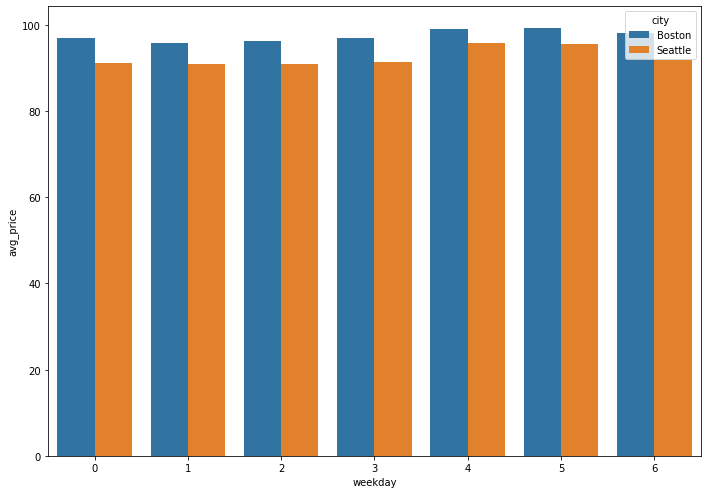

In [74]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

data_graph1 = calendar_all.drop(['listing_id'], axis = 1).groupby(['weekday', 'city']).mean().reset_index().rename(columns={'price':'avg_price'})
sns.barplot(x='weekday', y='avg_price', hue = 'city', data=data_graph1, ax = ax);

4.2 Look for patterns in the price, type and area 

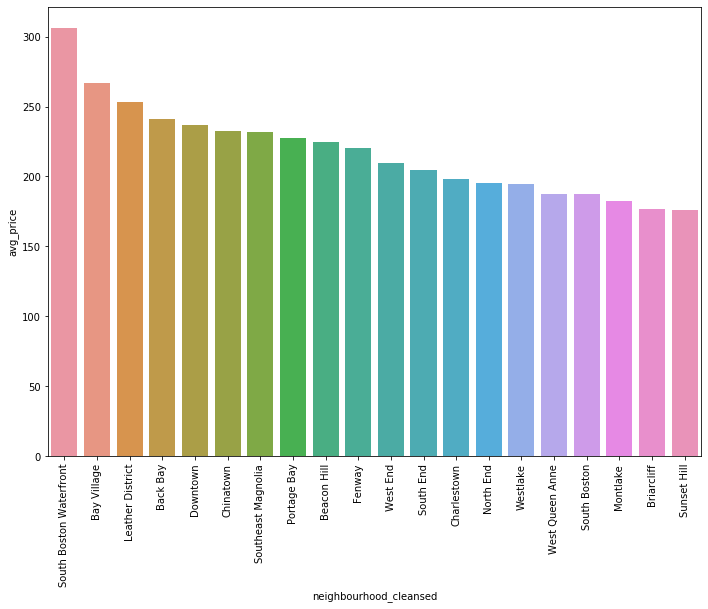

In [75]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

data_graph2 = listing_clean[['neighbourhood_cleansed','price']].groupby(['neighbourhood_cleansed']).mean().nlargest(20, 'price').reset_index().rename(columns={'price':'avg_price'})
sns.barplot(x='neighbourhood_cleansed', y='avg_price', data=data_graph2, ax = ax);
plt.xticks(rotation=90);

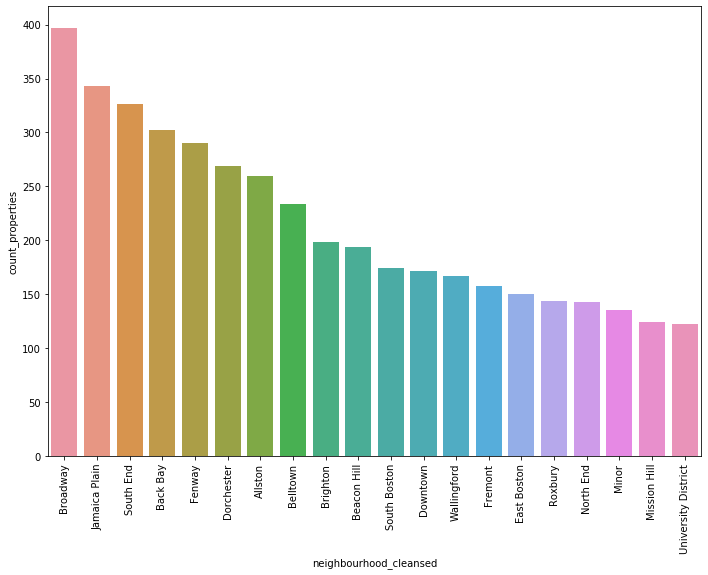

In [76]:
# count of properties by location 
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
data_graph3 = listing_clean[['neighbourhood_cleansed','host_id']].groupby(['neighbourhood_cleansed']).count().nlargest(20, 'host_id').reset_index().rename(columns={'host_id':'count_properties'})
sns.barplot(x='neighbourhood_cleansed', y='count_properties', data=data_graph3, ax = ax);
plt.xticks(rotation=90);

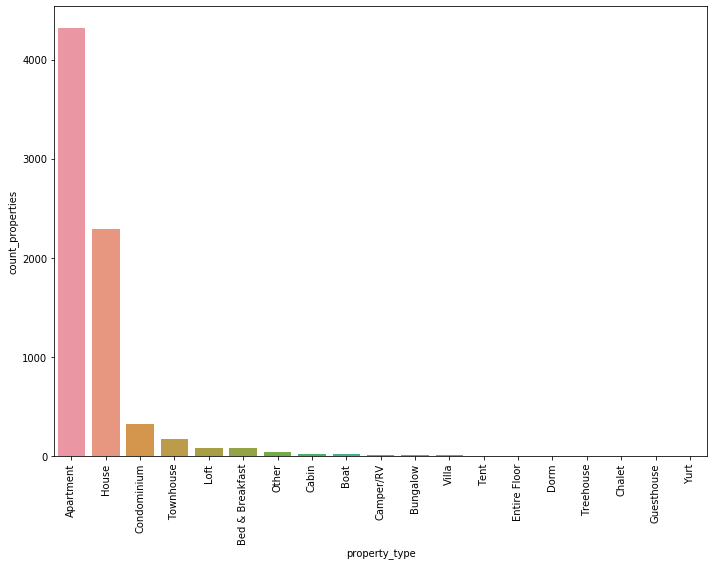

In [77]:
# count of properties by property type 
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
data_graph3 = listing_clean[['property_type','host_id']].groupby(['property_type']).count().sort_values('host_id',ascending=False).reset_index().rename(columns={'host_id':'count_properties'})
sns.barplot(x='property_type', y='count_properties', data=data_graph3, ax = ax);
plt.xticks(rotation=90);

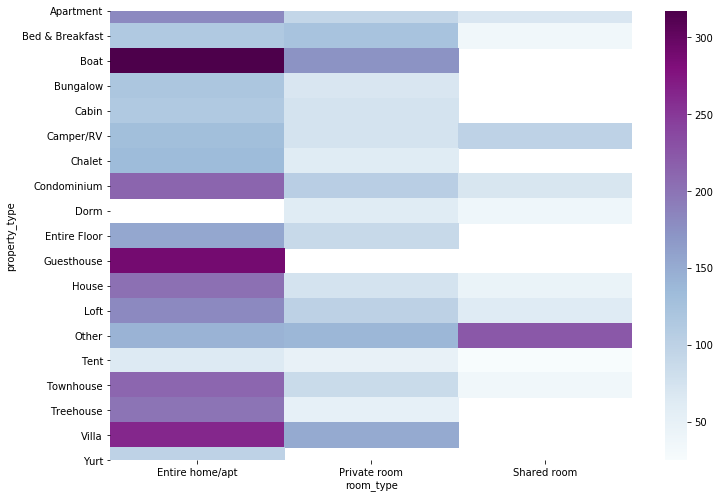

In [78]:
# look at property type and price 
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
                                                             
heatmap1_data = pd.pivot_table(listing_clean, values='price', 
                     index=['property_type'], 
                     columns='room_type')


sns.heatmap(heatmap1_data, ax = ax, cmap="BuPu");

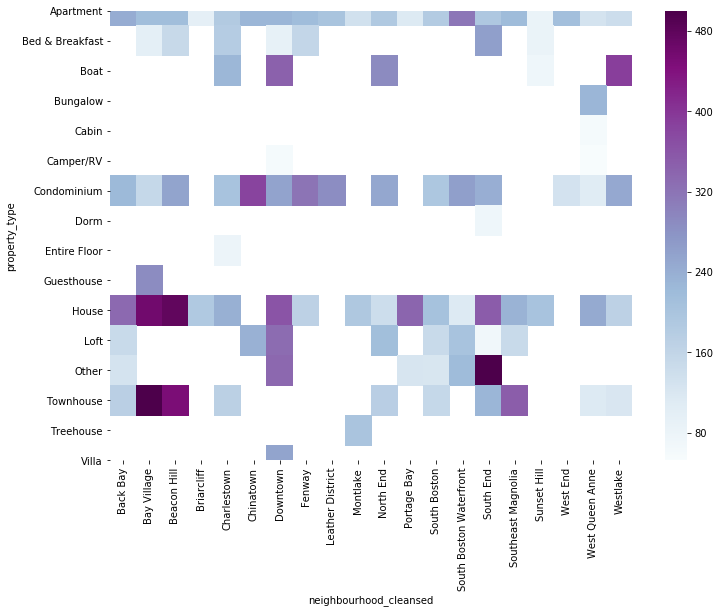

In [79]:
# look at relationship between area and propoerty type 
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
top20 = listing_clean[listing_clean.neighbourhood_cleansed.isin(['South Boston Waterfront','Bay Village','Leather District','Back Bay','Downtown','Chinatown','Southeast Magnolia','Portage Bay','Beacon Hill','Fenway','West End','South End','Charlestown','North End','Westlake','West Queen Anne','South Boston','Montlake','Briarcliff','Sunset Hill'])]
                                                             
heatmap2_data = pd.pivot_table(top20, values='price', 
                     index=['property_type'], 
                     columns='neighbourhood_cleansed')


sns.heatmap(heatmap2_data, ax = ax, cmap="BuPu");

### 5. Data Modeling and Evaluation 
5.1 Building and training model


In [80]:
#change categorical data to integers
listing_clean_cat = listing_clean_cat.drop(['id', 'host_id'], axis = 1)
dummy_col_df = pd.get_dummies(listing_clean_cat, dummy_na=True)
dummy_col_df.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_identity_verified_f,host_identity_verified_t,...,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_nan,require_guest_profile_picture_f,require_guest_profile_picture_t,require_guest_profile_picture_nan,require_guest_phone_verification_f,require_guest_phone_verification_t,require_guest_phone_verification_nan
0,0,0,0,1,0,1,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
1,0,0,0,1,0,1,0,0,0,1,...,1,0,0,0,1,0,0,1,0,0
2,0,0,1,0,0,0,1,0,0,1,...,1,0,0,0,0,1,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,0,0,0,1,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,0


In [81]:
# combine data for model
df_model = pd.concat([dummy_col_df,listing_clean_num], axis = 1)
df_model.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_time_nan,host_is_superhost_f,host_is_superhost_t,host_is_superhost_nan,host_identity_verified_f,host_identity_verified_t,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_value,calculated_host_listings_count,reviews_per_month
0,0,0,0,1,0,1,0,0,1,0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,0,0,0,1,0,1,0,0,0,1,...,359,36,94.0,10.0,9.0,10.0,10.0,9.0,1,1.30
2,0,0,1,0,0,0,1,0,0,1,...,319,41,98.0,10.0,9.0,10.0,10.0,10.0,1,0.47
3,0,0,1,0,0,1,0,0,1,0,...,98,1,100.0,10.0,10.0,10.0,10.0,10.0,1,1.00
4,0,0,0,1,0,0,1,0,0,1,...,334,29,99.0,10.0,10.0,10.0,10.0,10.0,1,2.25


In [82]:
# scaled data
scaler = preprocessing.StandardScaler()
df_model_scaled = pd.DataFrame(data = scaler.fit_transform(df_model), index = df_model.index, columns = df_model.columns)


X = df_model_scaled.drop('price', axis = 1)

y = df_model_scaled['price']


# Splitting the data into the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

fit_params={
    "early_stopping_rounds":10, 
            "eval_metric" : 'mae', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto' 
           }

model = lgb.LGBMRegressor(num_leaves= 100, max_depth=7, 
                         random_state=42,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=4000,
                         
                         learning_rate=0.01)

# Traning the model
model.fit(X_train, y_train, **fit_params)
    
    

Training until validation scores don't improve for 10 rounds
[100]	valid's l1: 0.395069
[200]	valid's l1: 0.342434
[300]	valid's l1: 0.327219
[400]	valid's l1: 0.320514
Early stopping, best iteration is:
[468]	valid's l1: 0.318267


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
              importance_type='split', learning_rate=0.01, max_depth=7,
              metric='None', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=4000, n_jobs=4, num_leaves=100,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [83]:
# predicting X_test
y_pred = model.predict(X_test)
r_squared = r2_score(y_test, y_pred)
root_mse = np.sqrt(mean_squared_error(y_test, y_pred))
importances = model.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})

In [84]:
#Accuracy for test
print({'r_squared on test data set':r_squared})
print({'root mse on test data set':root_mse})
print(tree_result)



{'r_squared on test data set': 0.6104003892604632}
{'root mse on test data set': 0.5410980980574799}
                                     feature  importance
0      host_response_time_a few days or more           0
1            host_response_time_within a day          81
2      host_response_time_within a few hours         194
3          host_response_time_within an hour         147
4                     host_response_time_nan          95
...                                      ...         ...
22734                  review_scores_checkin          85
22735            review_scores_communication          64
22736                    review_scores_value         145
22737         calculated_host_listings_count         453
22738                      reviews_per_month        1731

[22739 rows x 2 columns]


In [85]:
# predicting X_train
y_pred_train = model.predict(X_train)
r_squared_train = r2_score(y_train, y_pred_train)
root_mse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
importances = model.feature_importances_
feat_names = X_train.columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})

In [86]:
#Accuracy for train
print({'r_squared on train data set':r_squared_train})
print({'root mse on train data set':root_mse_train})

{'r_squared on train data set': 0.6241717106406595}
{'root mse on train data set': 0.6318012673872477}


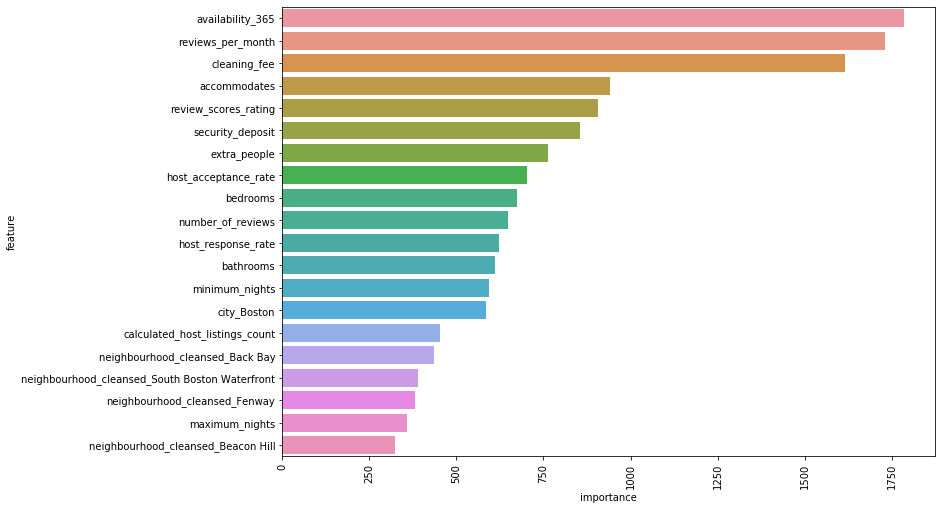

In [87]:
# Plotting features by importance
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
data_graph4 =tree_result.sort_values(by='importance',ascending=True).nlargest(20, 'importance')
sns.barplot(x='importance', y='feature', data=data_graph4, ax = ax);
plt.xticks(rotation=90);